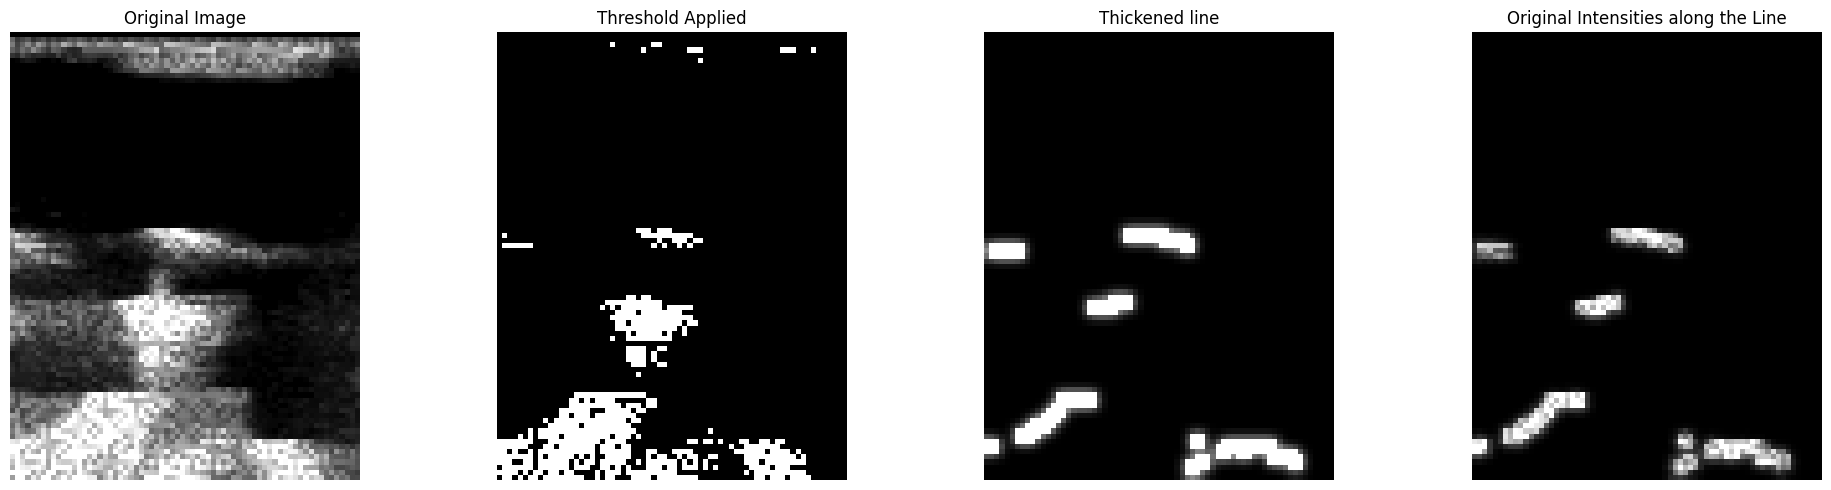

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_top_noise_and_keep_first_white(image_path,
                                          top_percent=0.90,
                                          top_margin=5,
                                          apply_closing=True):
    """
    top_percent:   The percentile of the histogram at which to set the threshold
                   (e.g., 0.90 = 90%, meaning the top 10% intensity becomes white).
    top_margin:    The width (in pixels) of the top region considered as 'top noise'.
                   Components starting above this margin are removed.
                   (This is common in ultrasound images.)
    apply_closing: If True, apply morphological closing to make the white spots more connected.
    """

    # 1) Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise IOError(f"Failed to load the image: {image_path}")

    # 2) Compute the histogram and cumulative distribution to identify the most intense pixels
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / float(cdf[-1])

    # Determine the threshold based on pixel intensity
    threshold_idx = np.where(cdf_normalized >= top_percent)[0]
    if len(threshold_idx) == 0:
        threshold_value = 255
    else:
        threshold_value = threshold_idx[0]

    # 3) Create a binary mask
    mask = (image >= threshold_value).astype(np.uint8) * 255

    if apply_closing:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # 6) Remove components that start at the top of the image – these parts are considered noiy.
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if y < top_margin:
            mask[labels == i] = 0

    # 7) For each column, select the first pixel above the threshold
    height, width = mask.shape
    contour_mask = np.zeros_like(mask)
    for col in range(width):
        col_pixels = mask[:, col]
        white_indices = np.where(col_pixels == 255)[0]
        if len(white_indices) > 0:
            topmost = white_indices[0]
            contour_mask[topmost, col] = 255

    # 8) Dilate the mask
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dilated_mask = cv2.dilate(contour_mask, dilation_kernel, iterations=1)

    # 9) Thicken the line using Gaussian Blur and then set white values:
    smooth_mask = cv2.GaussianBlur(dilated_mask, (5,5), 0)
    smooth_mask[dilated_mask == 255] = 255

    # 10) Mask the original image with the smooth_mask.
    #     Normalize smooth_mask to the range 0-1.
    smooth_mask_normalized = smooth_mask.astype(np.float32) / 255.0
    # The original intensity values are applied where the thickened (blurred) mask is present.
    masked_image = (image.astype(np.float32) * smooth_mask_normalized).astype(np.uint8)

    return image, threshold_value, smooth_mask, masked_image

if __name__ == "__main__":

    # Specify the PNG file(s)



    #image_path = "transformation_curved_flat.test.png"
    #image_path = "sample_curved_cropped_01.png"
    image_path = "transformation_curved_flat_whole_test.png"

    # Parameters – explanation provided above
    top_percent  = 0.90
    top_margin   = 5
    apply_closing = True

    # Processing
    original, thresh_val, final_mask, masked_image = remove_top_noise_and_keep_first_white(
        image_path,
        top_percent=top_percent,
        top_margin=top_margin,
        apply_closing=apply_closing
    )

    # Create a mask for thresholding without morphological closing (for comparison)
    hist, bins = np.histogram(original.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / float(cdf[-1])
    threshold_idx = np.where(cdf_normalized >= top_percent)[0]
    if len(threshold_idx) == 0:
        raw_thresh = 255
    else:
        raw_thresh = threshold_idx[0]

    raw_mask = (original >= raw_thresh).astype(np.uint8) * 255

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # 1. Original Image
    axs[0].imshow(original, cmap="gray")
    axs[0].axis("off")
    axs[0].set_title("Original Image")

    # 2. Binary Image – white and black – based on thresholding
    axs[1].imshow(raw_mask, cmap="gray")
    axs[1].axis("off")
    axs[1].set_title("Threshold Applied")

    # 3. Thickened Lines (Smooth Contour Mask: Dilation + Blur)
    axs[2].imshow(final_mask, cmap="gray")
    axs[2].axis("off")
    axs[2].set_title("Thickened line")

    # 4. Masked Image – original intensities preserved along the line
    axs[3].imshow(masked_image, cmap="gray")
    axs[3].axis("off")
    axs[3].set_title("Original Intensities along the Line")

    plt.tight_layout()
    plt.show()
